# Lab11 Report

## st122314

In this lab, there are three parts to report which are the following:

    
- Visual Transformer(ViT) from scratch
    
- Pretrained Pytorch ViT and finetuning

### 1.Visual Transformer(ViT) from scratch

#### 1.1 Load data

In this part, MNIST dataset from the root directory were downloaded and put into dataloader for both train and test sets.

In [7]:
import numpy as np

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

# Loading data
transform = ToTensor()

train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=16)
test_loader = DataLoader(test_set, shuffle=False, batch_size=16)

#### 1.2 Train and Test functions

Train and test functions were employed for Visual Transformers according to the following cell. 

In [8]:
def train_ViT_classify(model, optimizer, N_EPOCHS, train_loader, device="cpu"):
    criterion = CrossEntropyLoss()
    for epoch in range(N_EPOCHS):
        train_loss = 0.0
        for batch in train_loader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y) / len(x)

            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")
        
def test_ViT_classify(model, optimizer, test_loader):
    criterion = CrossEntropyLoss()
    correct, total = 0, 0
    test_loss = 0.0
    for batch in test_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        y_hat = model(x)
        loss = criterion(y_hat, y) / len(x)
        test_loss += loss

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

#### 1.3 Multi-head Self Attention (MSA) Model

In [9]:
class MSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        self.k_mappings = [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        self.v_mappings = [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

#### 1.4 Position encoding

In [10]:
def get_positional_embeddings(sequence_length, d, device="cpu"):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result.to(device)

#### 1.5 ViT Model

Step 1: Patchifying and the linear mapping

Step 2: Adding the classification token

Step 3: Positional encoding

Step 4: LN, MSA, and Residual Connection

Step 5: LN, MLP, and Residual Connection

Step 6: Classification MLP


In [11]:
model = ViT((1, 28, 28), n_patches=7, hidden_d=20, n_heads=2, out_d=10)
model = model.to(device)

N_EPOCHS = 5
LR = 0.01
optimizer = Adam(model.parameters(), lr=LR)

train_ViT_classify(model, optimizer, N_EPOCHS, train_loader, device)

test_ViT_classify(model, optimizer, test_loader)


After running the model, the following figure is the training loss for each epochs. Then, Test loss is 61.41 and test accuracy is  88.88%

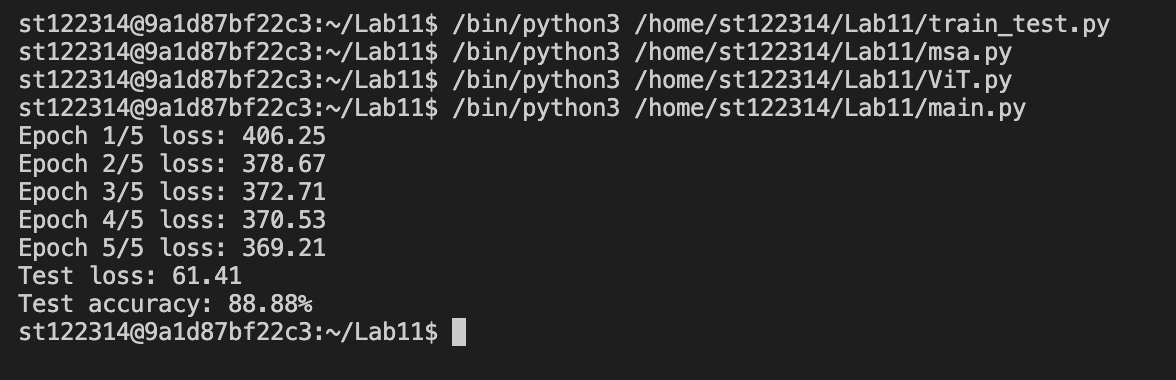

### 2. Pytorch Pre-trained ViT and fine-tuning

#### 2.1 Pre-trained ViT 

In [12]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.datasets.mnist import MNIST
from torchvision import transforms
from vit_pytorch import ViT

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

##### 2.1.1 Loading Data 

ImageNet from the root path is employed to load as train data and validation data after making image tranformation:
resize to 256 pixels, randomcrop and randomhorizontalflip. Then, all were put into DataLoader.

In [ ]:
# Load data.

print("Loading ImageNet train ...")
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
    )

train_set = datasets.ImageNet(root='/Dataset/ImageNet',
#train_set = datasets.ImageNet(root='/home/fidji/mdailey/Datasets/Imagenet',
        split = 'train', 
        transform=train_transform)

print("Loading ImageNet val ...")
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
    )

val_set = datasets.ImageNet(root='/Dataset/ImageNet',
#val_set = datasets.ImageNet(root='/home/fidji/mdailey/Datasets/Imagenet',
        split = 'val', 
        transform=val_transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=48, num_workers=4)
val_loader = DataLoader(val_set, shuffle=True, batch_size=48, num_workers=4)

##### 2.1.2 Training function

In [ ]:
def train(model, optimizer, N_EPOCHS, device, train_loader):
    criterion = CrossEntropyLoss()
    for epoch in range(N_EPOCHS):
        train_loss = 0.0
        epoch_start = time.time()
        for i, (batch) in enumerate(train_loader):
            model = model.to(device)
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            # print('x shape: ', x.shape)
            y_hat = model(x)
            loss = criterion(y_hat, y) / len(x)

            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i % 100 == 0):
                print(f'Iteration {i}: train loss {loss.item()}')
                print(f'Time Elapsed: {time.time() - epoch_start} seconds')
                print("----------------------")

            if (i % 20000 == 0):
                torch.save(model.state_dict(), f'model_epoch_{i}.pt')
        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss/ len(train_loader):.2f}")

##### 2.1.3 Testing function

In [ ]:
def test(model, device, test_loader):
    criterion = nn.CrossEntropyLoss()
    correct, total = 0, 0
    test_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            
            y_hat = model(x)
            loss = criterion(y_hat, y) / len(x)
            test_loss += loss

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

##### 2.1.4 Pre-trained Visual Transformer(ViT) Model

In this ViT model, the image size of 224 was firstly splitted into patch size 16 and used 1024 dimmension with depth 16 and total 6 multi heads. Moreover, 2048 multi layer percetron were employed before 0.1 drop out rate and embedded dropout.

In [ ]:
model = ViT(
    image_size = 224,
    patch_size = 16,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

##### 2.1.5 Training 

In training part, total 5 epochs, 0.001 learning rate and Adam optimizer were used. Then, training model started after counting time and model was saved.

In [ ]:
N_EPOCHS = 5
LR = 0.001
optimizer = Adam(model.parameters(), lr=LR)


start_training = time.time()
train(model, optimizer, N_EPOCHS, device, train_loader)

torch.save(model.state_dict(), 'trained-pytorch-vit-imagenet.pt')
print(f"Total Training Time: {time.time() - start_training} seconds")

The follwing cell is the reult of training which is total 5 epochs and 26,000 iterations per epoch. Futhermore, it takes around 15 hrs (52038.67340183258 seconds).

According to the above train loss result, the pre-trained model I applied does not seem learning.

##### 2.1.5 Testing

In [ ]:
test(model, device, test_loader)
print(len(val_loader))

# print("Loading Model Checkpoint ...")
# model.load_state_dict(torch.load('trained-vit.pt'))

test(model, device, val_loader)

The following pic shows the test result.

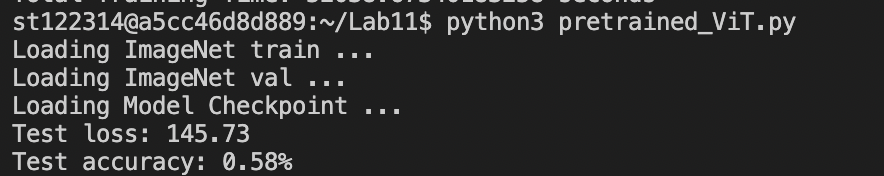

#### 2.2 fine-tuning with CIFAR10

In [ ]:

import numpy as np
import time
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.datasets.mnist import MNIST
from torchvision import transforms
from vit_pytorch import ViT

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Load data.

print("Loading CIFAR10 train ...")
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
    )

train_set = datasets.CIFAR100(root='/Dataset/CIFAR10',
                            train = True, download= True,
                            transform=train_transform)


val_set = datasets.CIFAR100(root='/Dataset/CIFAR10',
                            train = False, download= True,
                            transform=train_transform)


train_loader = DataLoader(train_set, shuffle=True, batch_size=48, num_workers=4)
print(len(train_loader))
val_loader = DataLoader(val_set, shuffle=True, batch_size=48, num_workers=4)

model = ViT(
    image_size = 224,
    patch_size = 16,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)


print("Loading Model Checkpoint ...")
model.load_state_dict(torch.load('trained-pytorch-vit-imagenet.pt'))

def train(model, optimizer, N_EPOCHS, device, train_loader):
    criterion = CrossEntropyLoss()
    for epoch in range(N_EPOCHS):
        train_loss = 0.0
        epoch_start = time.time()
        for i, (batch) in enumerate(train_loader):
            model = model.to(device)
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            # print('x shape: ', x.shape)
            y_hat = model(x)
            loss = criterion(y_hat, y) / len(x)

            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i % 100 == 0):
                print(f'Iteration {i}: train loss {loss.item()}')
                print(f'Time Elapsed: {time.time() - epoch_start} seconds')
                print("----------------------")

            if (i % 20000 == 0):
                torch.save(model.state_dict(), f'model_epoch_{i}.pt')
        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss/ len(train_loader):.2f}")


def test(model, device, test_loader):
    criterion = nn.CrossEntropyLoss()
    correct, total = 0, 0
    test_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            
            y_hat = model(x)
            loss = criterion(y_hat, y) / len(x)
            test_loss += loss

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")
        

N_EPOCHS = 5
LR = 0.001
optimizer = Adam(model.parameters(), lr=LR)

model.mlp_head[1] = nn.Linear(in_features = 1024, out_features = 10, bias = True)

start_training = time.time()
train(model, optimizer, N_EPOCHS, device, train_loader)

print(f"Total Training Time: {time.time() - start_training} seconds")

test(model, device, val_loader)

The following is the testing result on CIFAR10.

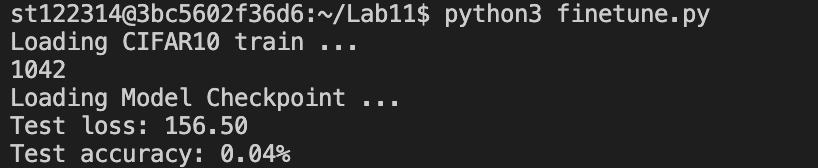